In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [42]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=2)
pd.options.display.float_format = "{:,.2f}".format

# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9
MAX_EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 50
BASE_LEARNING_RATE = 0.001
BATCH_SIZE = 64

In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= False, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))
    
#Pre-Processing
def one_hot(img, label):
    return (img, tf.one_hot(label,9))

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 192
Number of validation samples: 55
Number of test samples: 28


In [44]:
def loadDatasetEagerly(ds):
    ds_numpy = tfds.as_numpy(ds)
    X_batches = []
    y_batches = []
    for X_batch, y_batch in ds_numpy:
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    X_batches = tuple(X_batches)
    y_batches = tuple(y_batches)
    X = np.concatenate(X_batches, axis = 0)
    y = np.concatenate(y_batches, axis = 0)
    return X, y

X_train, y_train = loadDatasetEagerly(train_ds)

In [45]:
#model_builder = keras.applications.xception.Xception
img_size = (256, 256)
#preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions
cv2.imread(
last_conv_layer_name = "conv5_block3_out"

# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

#display(Image(img_path))


In [54]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    #img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    #array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    inner_model = model.get_layer('resnet50')

    grad_model = tf.keras.models.Model(
        [inner_model.inputs], [inner_model.get_layer(last_conv_layer_name).output, inner_model.output]
    )
    
    #grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('resnet50').get_layer('conv5_block3_out').output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        last_conv_layer_output, preds = grad_model(img_array)
        
        preds = model.get_layer('global_average_pooling2d')(preds)
        preds = model.get_layer('dropout')(preds)
        preds = model.get_layer('dense')(preds)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        print(pred_index)
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

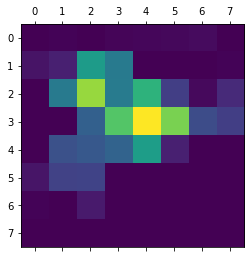

In [65]:
# Prepare image
img_path = "20171109-091016-2.jpg"

#img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = cv2.imread(img_path)


img_array = np.expand_dims(img_array, axis=0)


# Make model
#model = model_builder(weights="imagenet")
model = tf.keras.models.load_model('resnet_model')
model.summary()

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


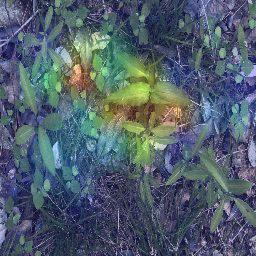

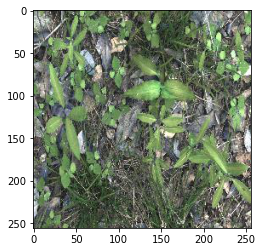

In [66]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)
    img = cv2.imread(img_path)



    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)
plt.imshow(cv2.imread(img_path))